In [3]:
import os
import netCDF4
import numpy as np
from matplotlib import pyplot as plt

folder_path = '/home/yasser.attia/Templates/inference/'

# Get a list of file names within the folder
file_names = os.listdir(folder_path)
print(file_names)

i=0
for file_name in file_names:
    if '.nc' in file_name:
        print(file_name)
        sinmod = netCDF4.Dataset(folder_path+file_name)
        salinity = np.array(sinmod['salinity'])
        u = np.array(sinmod['u_east'])
        v = np.array(sinmod['v_north'])
        s0=salinity.shape[0]
        s1=salinity.shape[1]
        for idx1 in range(s0):
            for idx2 in range(s1):
                salinity[idx1,idx2,:,:]= np.clip(salinity[idx1,idx2,:,:],-10,30)

        for idx1 in range(s0):
            for idx2 in range(s1):
                u[idx1,idx2,:,:]= np.clip(u[idx1,idx2,:,:],-2,2)
        for idx1 in range(s0):
            for idx2 in range(s1):
                v[idx1,idx2,:,:]= np.clip(u[idx1,idx2,:,:],-2,2)
        if i==0:
            i=i+1
            Data_s=salinity[0:s0-1]
            Data_ss=salinity[1:s0]
            Data_u=u[0:s0-1]
            Data_v=v[0:s0-1]

        else:
            Data_s=np.concatenate((Data_s,salinity[0:s0-1]),axis=0)
            Data_ss=np.concatenate((Data_ss,salinity[1:s0]),axis=0)
            Data_u=np.concatenate((Data_u,u[0:s0-1]),axis=0)
            Data_v=np.concatenate((Data_v,v[0:s0-1]),axis=0)

        print(salinity.shape)



['project_5.ipynb', 'samples_2021.05.28.nc', 'project.ipynb', 'mnm.ipynb', 'samples_2021.05.29.nc', 'Data_v.npy', 'mm.ipynb', 'samples_2022.09.08.nc', 'samples_2022.06.22.nc', 'samples_2022.09.09.nc', 'samples_2022.06.21.nc', 'project_linear.ipynb', 'Outputs', 'Data_s.npy', 'Load_data.ipynb', 'project1.ipynb', 'Data_ss.npy', 'samples_2021.05.26.nc', 'project copy.ipynb', 'samples_2021.05.27.nc', 'project_3.ipynb', 'Outputs_learning curve.png', 'SINMOD.ipynb', 'samples_2022.05.04.nc', 'Data_u.npy', 'project_2.ipynb', 'samples_2022.05.11.nc', 'samples_2022.05.10.nc', 'lstm_model.pth']
samples_2021.05.28.nc
(144, 25, 119, 149)
samples_2021.05.29.nc
(144, 25, 119, 149)
samples_2022.09.08.nc
(144, 25, 119, 149)
samples_2022.06.22.nc
(72, 25, 119, 149)
samples_2022.09.09.nc
(144, 25, 119, 149)
samples_2022.06.21.nc
(144, 25, 119, 149)
samples_2021.05.26.nc
(144, 25, 119, 149)
samples_2021.05.27.nc
(144, 25, 119, 149)
samples_2022.05.04.nc
(144, 25, 119, 149)
samples_2022.05.11.nc
(120, 25, 1

In [4]:
Data_s=Data_s.reshape(-1,1,119,149)
Data_ss=Data_ss.reshape(-1,1,119,149)
Data_u=Data_u.reshape(-1,1,119,149)
Data_v=Data_v.reshape(-1,1,119,149)

In [5]:
Data_s.shape

(36150, 1, 119, 149)

In [6]:
Data_s=Data_s[0:25000,:,:,:]
Data_ss=Data_ss[0:25000,:,:,:]
Data_u=Data_u[0:25000,:,:,:]
Data_v=Data_v[0:25000,:,:,:]

In [7]:
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
all_segments=torch.tensor(np.concatenate((Data_s,Data_u,Data_v),axis=1), dtype=torch.float)
all_labels = torch.tensor(Data_ss, dtype=torch.float)
combined_dataset = TensorDataset(all_segments, all_labels)
k_folds = 5
fold_size = len(combined_dataset) // k_folds

In [9]:
import torch
import torch.nn as nn

class ConvGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvGRUCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.bias = bias
        self.padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        
        self.conv = nn.Conv2d(in_channels=input_dim + hidden_dim,
                              out_channels=2 * hidden_dim,  
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)
        self.conv_candidate = nn.Conv2d(in_channels=input_dim + hidden_dim,
                                        out_channels=hidden_dim,  
                                        kernel_size=self.kernel_size,
                                        padding=self.padding,
                                        bias=self.bias)

    def forward(self, input_tensor, h_cur):
        combined = torch.cat([input_tensor, h_cur], dim=1)
        gates = self.conv(combined)
        r_gate, z_gate = torch.split(gates, self.hidden_dim, dim=1)
        r = torch.sigmoid(r_gate)
        z = torch.sigmoid(z_gate)
        
        combined_candidate = torch.cat([input_tensor, r * h_cur], dim=1)
        h_tilde = torch.tanh(self.conv_candidate(combined_candidate))
        h_next = (1 - z) * h_tilde + z * h_cur
        
        return h_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device)

class ConvGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, bias=True):
        super(ConvGRU, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.bias = bias
        
        self.layers = nn.ModuleList([ConvGRUCell(input_dim, hidden_dim, kernel_size, bias) for _ in range(num_layers)])

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=input_dim, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_dim, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )
    
    def forward(self, x):
        batch_size, channels, height, width = x.shape
        
        # Pass the input through the encoder
        encoded_x = self.encoder(x)
        
        hidden = self.layers[0].init_hidden(batch_size, (height, width))
        for layer in self.layers:
            hidden = layer(encoded_x, hidden)

        # Decode the output
        decoded = self.decoder(hidden)
        return decoded



In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
time_steps = 1
channels = 3
height = 119
width = 149
batch_size = 64
num_epochs = 25


num_samples = len(all_segments)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size

train_dataset, val_dataset = random_split(TensorDataset(all_segments, all_labels), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [28]:
model = ConvGRU(input_dim=channels, hidden_dim=64, kernel_size=(3, 3), num_layers=1).to(device)
model.load_state_dict(torch.load("/home/yasser.attia/Templates/inf/grn_model_30.pth"))
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

156996

In [ ]:
# Model Configuration
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training Loop
for epoch in range(5):
    model.train()

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        sequences, labels = data
        sequences = sequences.to(device)
        labels = labels.to(device)
        #sequences=sequences[:,0:1,:,:,:]
        #print(sequences.shape)

        optimizer.zero_grad()
        outputs = model(sequences)
        #print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:  # print every 10 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 10:.3f}')
            running_loss = 0.0

    # Validation Loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for data in val_loader:
            sequences, labels = data
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        print(f'Validation Loss: {val_loss / len(val_loader):.3f}')

print('Finished Training')


In [ ]:
model.eval()
outs=[]
labs=[]
los=[]
LOSS_tot=0
for i in range(sequences.shape[0]):
        seq=sequences[i:i+1,:,:,:]
        lab=labels[i:i+1,:,:]
        seq = seq.to(device)
        lab = lab.to(device)
        #outputs, _ = model(seq)
        
        if i==0:
                outputs= model(seq)
        else:
                seq[:,0,:,:]=outputs
                outputs= model(seq)
        loss = criterion(outputs, lab)
        outs.append(outputs)
        labs.append(lab)

        LOSS_tot+=loss.item()
        los.append(LOSS_tot/(i+1))
        print(LOSS_tot/(i+1))

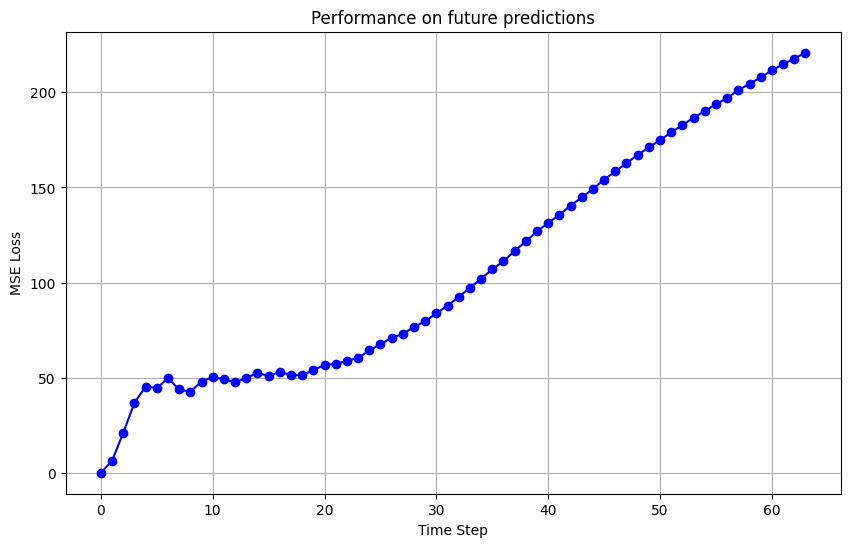

In [33]:
time_steps = range(len(los))

# Plot the loss values over time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, los, marker='o', linestyle='-', color='b')
plt.xlabel("Time Step")
plt.ylabel("MSE Loss")
plt.title("Performance on future predictions")
plt.grid(True)
plt.show()